#### Example for getting spacecraft positions with sunpy

In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

import astropy
import sunpy
import astroquery  
from sunpy.coordinates import frames, get_horizons_coord


In [20]:
#Solar Orbiter
coord = get_horizons_coord('Solar Orbiter', time={'start': '2022-09-01', 'stop': '2022-09-30', 'step': '60m'})  
solo_heeq = coord.transform_to(frames.HeliographicStonyhurst) #HEEQ
solo_hee = coord.transform_to(frames.HeliocentricEarthEcliptic)  #HEE

solo_time=solo_heeq.obstime.to_datetime()
solo_r=solo_heeq.radius.value
solo_lon=np.deg2rad(solo_heeq.lon.value)
solo_lat=np.deg2rad(solo_heeq.lat.value)


#PSP
coord = get_horizons_coord('Parker Solar Probe', time={'start': '2022-09-01', 'stop': '2022-09-30', 'step': '60m'})  
psp_heeq=coord.transform_to(frames.HeliographicStonyhurst)

psp_time=psp_heeq.obstime.to_datetime()
psp_r=psp_heeq.radius.value
psp_lon=np.deg2rad(psp_heeq.lon.value)
psp_lat=np.deg2rad(psp_heeq.lat.value)

    

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Parker Solar Probe (spacecraft) [sunpy.coordinates.ephemeris]


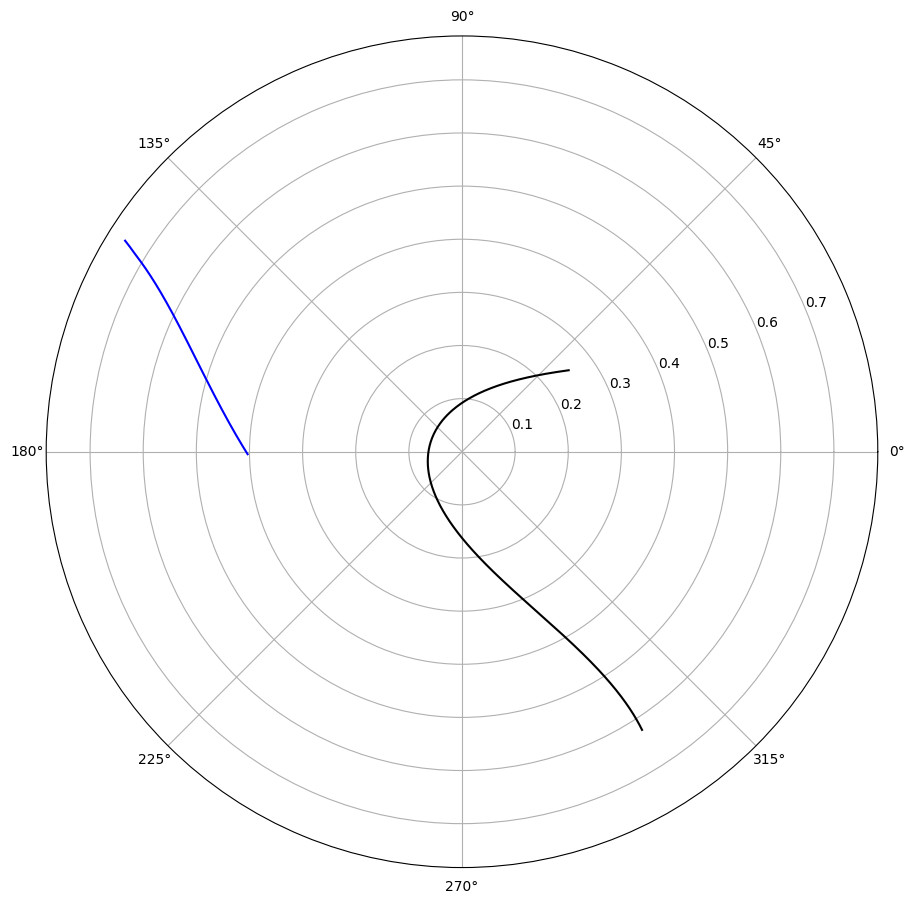

In [23]:
%matplotlib inline

fig=plt.figure(1, figsize=(19.2,10.8), dpi=100) #full hd
ax = plt.subplot2grid((1,1), (0, 0), rowspan=7, projection='polar')

plt.plot(solo_lon,solo_r,'b')
plt.plot(psp_lon,psp_r,'k')

